In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import jax
from jax.scipy.special import gammaln
from jax import random
from tqdm import tqdm 

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops, get_cg_vol_ops
from src.algorithm import conjugate_gradient as cg
from src.algorithm import oasis, oasis_adaptive
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *

plt.rcParams["figure.figsize"]=6,6

In [3]:
key = random.PRNGKey(12)

In [4]:
B = 300 # Number of operators (and images, B=N)
d = B # Image dimension

In [5]:
key, subkey = random.split(key)
x0 = 10 + random.normal(subkey, (d,))

In [6]:
# Generate operators 

A = np.zeros((B, d, d))
for i in range(0,B):
    #print(i)
    diag_i = np.ones(d)
    diag_i[:(i+1)] = 0

    A[i] = np.diag(diag_i)

In [7]:
# Generate measurements
b = jnp.array([Ai@x0 for Ai in A])

# Add noise to the measurements
key, subkey = random.split(key)

sigma = 0.001

b = b + random.normal(subkey, b.shape) * sigma



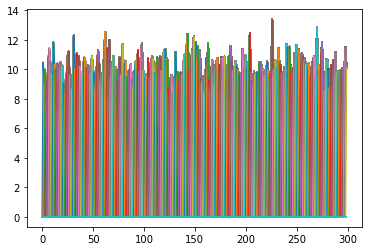

In [8]:
for i in range(b.shape[0]):
    plt.plot(b[i])


In [9]:
@jax.jit
def loss_term(x, Ai, bi, alpha):
    return 1/2*jnp.sum(jnp.conj(Ai@x-bi)*(Ai@x-bi)) + alpha * jnp.sum(jnp.conj(x)*x)

@jax.jit
def loss_sum(x, A, b, alpha):
    return jnp.mean(jax.vmap(loss_term, in_axes = (None, 0, 0, None))(x, A, b, alpha))

@jax.jit
def grad_term(x, Ai, bi, alpha):
    return jax.grad(loss_term)(x, Ai, bi, alpha)



In [10]:
#print(loss_term(x0,A[0],b[0], 1))
#print(loss_sum(x0, A, b, 1))
#print(grad_term(x0,A[0],b[0], 1))

### GD

In [12]:
alpha = 0.001

In [13]:
AA = jnp.sum(jax.vmap(lambda Ai : Ai.T @ Ai, in_axes = 0)(A), axis = 0)

D = jnp.diag(AA)+d * alpha
u, v = jnp.linalg.eigh(AA)

In [14]:
P = 1/D
#P = jnp.ones(x0.shape)

In [15]:

key, subkey = random.split(key)
x = random.normal(subkey, x0.shape)
cost = [loss_sum(x, A, b, alpha)]

err_b = [b[0,1]/(1+alpha*B) - x[1]]

#eta = 0.001
eta = 1

epochs = 3000
for epoch in tqdm(range(epochs)):
    x = x - eta * P * jnp.sum(jax.vmap(grad_term, in_axes = (None, 0, 0, None))(x, A, b, alpha), axis=0)
    cost.append(loss_sum(x, A, b, alpha))
    err_b.append(b[0,1]/(1+alpha*B) - x[1])
            
cost = jnp.array(cost)
err_b = jnp.array(err_b)
err = jnp.abs(x0-x)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:35<00:00, 31.49it/s]


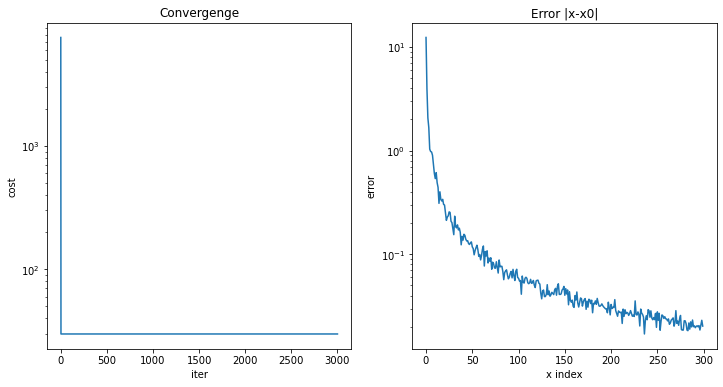

In [16]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(121)
plt.semilogy(cost)
plt.xlabel('iter')
plt.ylabel('cost')
plt.title('Convergenge')

plt.subplot(122)
plt.semilogy(err)

plt.xlabel('x index')
plt.ylabel('error')
plt.title('Error |x-x0|')

plt.rcParams["figure.figsize"]=6,6

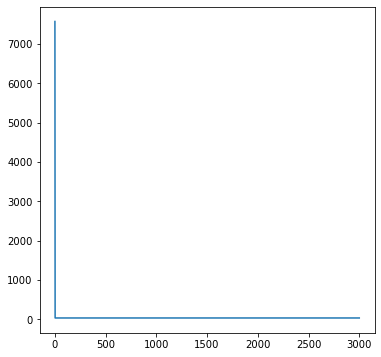

In [17]:
plt.plot(cost)

In [18]:
print(x0[0])
print(x[0])
print(err[0])

10.86859505517294
-1.4572438397741012
12.32583889494704


In [19]:
print(b[0,1]/(1+alpha*B))
print(x0[1])
print(x[1])
print(err[1])
print(err_b[-1])

8.069839774775968
10.491370420663639
6.556744817005477
3.934625603658162
1.513094957770491


In [20]:
print(x0[d-1])
print(x[d-1])
print(err[d-1])
print(f"sigma={sigma}")

10.113067440328582
10.092764785428969
0.020302654899612804
sigma=0.001


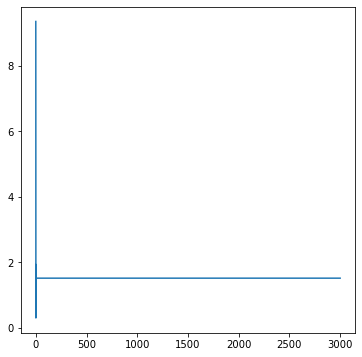

In [21]:
plt.plot(jnp.abs(err_b))

### "SGD"

In [22]:
alpha = 0.001

key, subkey = random.split(key)
x = random.normal(subkey, x0.shape)
cost = [loss_sum(x, A, b, alpha)]

err_b = [b[0,1]/(1+alpha*B) - x[1]]

#eta = 0.01

eta = 1


epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch}")
    for i in tqdm(range(B)):
        x = x - eta * P * grad_term(x, A[i], b[i], alpha)
        cost.append(loss_sum(x, A, b, alpha))
        err_b.append(b[0,1]/(1+alpha*B) - x[1])
            
cost = jnp.array(cost)
err_b = jnp.array(err_b)
err = jnp.abs(x0-x)


Epoch 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 86.47it/s]


Epoch 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 87.55it/s]


Epoch 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 86.75it/s]


Epoch 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 87.80it/s]


Epoch 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 87.14it/s]


Epoch 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 86.89it/s]


Epoch 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 86.49it/s]


Epoch 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 87.98it/s]


Epoch 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 87.09it/s]


Epoch 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 87.93it/s]


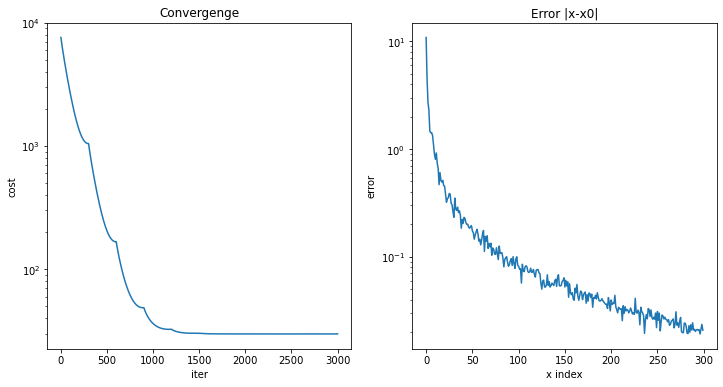

In [23]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(121)
plt.semilogy(cost)
plt.xlabel('iter')
plt.ylabel('cost')
plt.title('Convergenge')

plt.subplot(122)
plt.semilogy(err)

plt.xlabel('x index')
plt.ylabel('error')
plt.title('Error |x-x0|')

plt.rcParams["figure.figsize"]=6,6

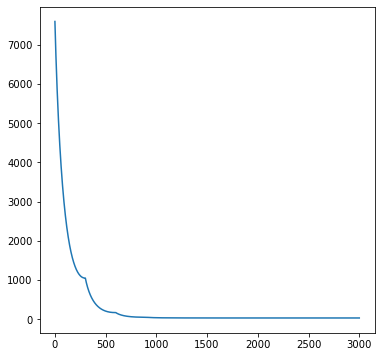

In [24]:
plt.plot(cost)

In [25]:
#print(f"x      = {x}")
#print(f"x0     = {x0}")
#print(f"Errors = {jnp.abs(x0-x)}")

In [26]:
print(x0[0])
print(x[0])
print(err[0])

10.86859505517294
-2.2014679598841524e-09
10.868595057374407


In [27]:
print(b[0,1]/(1+alpha*B))
print(x0[1])
print(x[1])
print(err[1])
print(err_b[-1])

8.069839774775968
10.491370420663639
5.953824324722966
4.537546095940673
2.116015450053002


In [28]:
print(x0[d-1])
print(x[d-1])
print(err[d-1])
print(f"sigma={sigma}")

10.113067440328582
10.092253413389598
0.020814026938984043
sigma=0.001


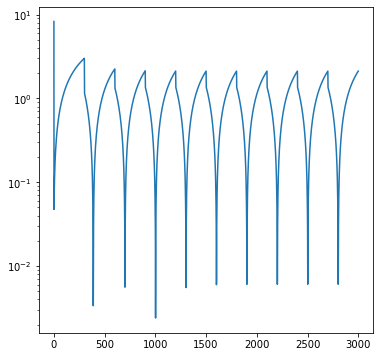

In [29]:
plt.semilogy(jnp.abs(err_b))

In [30]:
jnp.where(jnp.abs(err_b) < 1e-3)

(DeviceArray([], dtype=int64),)

In [31]:
jnp.mean(b)

DeviceArray(4.99578717, dtype=float64)

In [32]:
jnp.mean(x0)

DeviceArray(10.00705265, dtype=float64)